<a href="https://colab.research.google.com/github/taravatp/Panopic-Feature-Pyramid-Network/blob/main/DataLoaders/coco_semantic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the required libraris

In [ ]:
!pip install -qU torch_snippets
!pip install import_ipynb 
!pip install jsonlines

In [ ]:
import torch

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torch_snippets import *

from pycocotools.coco import COCO
from pycocotools import mask

import import_ipynb

# Defining the dataset

In [ ]:
class coco_semantic_dataset(Dataset):
      
  def __init__(self,flag):

    json_stuff = '/content/drive/MyDrive/panoptic_FPN/dataset/annotations/stuff_val2017.json'
    json_things = '/content/drive/MyDrive/panoptic_FPN/dataset/annotations/instances_val2017.json'
    self.root = '/content/drive/MyDrive/panoptic_FPN/dataset/val2017'

    self.cocoStuff = COCO(json_stuff)
    self.cocoThing = COCO(json_things)
    self.image_IDS = self.get_imageIDS()

    if flag == 'train':
      self.image_IDS = self.image_IDS[0:1500] #using only the first 1500 images for training
      self.images = self.cocoStuff.loadImgs(self.image_IDS) #loading images by their IDs -its a list of dictionaries 
    else: 
      self.image_IDS = self.image_IDS[1500:1700] #using only 200 images for testing
      self.images = self.cocoStuff.loadImgs(self.image_IDS) #loading images by their IDs - its a list of dictionaries 
    
    self.category_IDS = self.cocoStuff.getCatIds() #getting the ID of all the available categories
    self.categories = self.cocoStuff.loadCats(self.category_IDS) #loading categories by their IDs - each category is a dictionary

  def get_imageIDS(self):
    image_IDS_stuff = self.cocoStuff.getImgIds() #getting the ID of all images
    image_IDS_stuff = [item for item in image_IDS_stuff if len(self.cocoStuff.getAnnIds(item))!=0] #removing images which do not have any annotations

    image_IDS_things = self.cocoThing.getImgIds()
    image_IDS_things = [item for item in image_IDS_things if len(self.cocoThing.getAnnIds(item))!=0]

    image_IDS_stuff = set(image_IDS_stuff)
    image_IDS_things = set(image_IDS_things)
    image_IDS = list(image_IDS_stuff.intersection(image_IDS_things))

    return image_IDS

  def __len__(self):
    return len(self.images)
   
  def get_className(self,catIDs):
    print(f"before rescaling: {catIDs}")
    catIDs = catIDs + 92 #return to their original scale
    print(f"after rescaling: {catIDs}")
    category = self.cocoStuff.loadCats(catIDs)
    for i in range(len(category)):
      print(category[i]['name'])

  def __getitem__(self,idx):

    image = self.images[idx]
    imageID = image['id'] #getting the id of that image

    image_path = os.path.join(self.root,image['file_name'])
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR) #all images are in BGR format
    original_image = cv2.resize(original_image, dsize=(480,640), interpolation=cv2.INTER_NEAREST)
    original_image = original_image.transpose(2,0,1) #(C-H-W)
    original_image = original_image/255 #normalizing
    original_image = torch.as_tensor(original_image, dtype=torch.float) #converting numpy to tensor

    annotation_IDS = self.cocoStuff.getAnnIds(imgIds=imageID) #getting the annotation ID of an image
    annotations = self.cocoStuff.loadAnns(annotation_IDS) #loading the annotations 

    labels = []
    areas = []
    masks = []
    segmentation_mask = np.zeros((original_image.shape[1],original_image.shape[2]))

    for i in range(len(annotations)):
      label = annotations[i]['category_id'] - 92 #rescaling - min value will be 0 - and max value will be 91
      label = torch.as_tensor(label,dtype=torch.int64)
      labels.append(label) #storing the labels of all the segments in an image

      area = annotations[i]['category_id'] 
      area = torch.as_tensor(area, dtype=torch.float32)
      areas.append(area) #storing the areas of all the segments in an image

      _mask = mask.decode(annotations[i]['segmentation']) #this mask will have 0 and 1 values
      _mask = np.where(_mask==1,label,_mask) #each pixel will have its class label
      _mask = cv2.resize(_mask, dsize=(480,640), interpolation=cv2.INTER_NEAREST) #masks will be resized
      segmentation_mask = np.maximum(segmentation_mask,_mask)     
      #masks.append(_mask)
    
    segmentation_mask = np.where(segmentation_mask==0,91,segmentation_mask) #fill the zero values with 91 wich refers to the 'other' class
    segmentation_mask = torch.as_tensor(segmentation_mask,dtype=torch.int64)
    imageID = torch.tensor([imageID])
    target = {}
    target['labels'] = labels
    target['mask'] = segmentation_mask
    target['areas'] = areas
    target['image_id'] = imageID
    

    return original_image,segmentation_mask

# experminet with a sample data and its ground truth annotations

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
Tensor	Shape: torch.Size([3, 640, 480])	Min: 0.000	Max: 1.000	Mean: 0.564	dtype: torch.float32
Tensor	Shape: torch.Size([640, 480])	Min: 4.000	Max: 91.000	Mean: 67.967	dtype: torch.int64


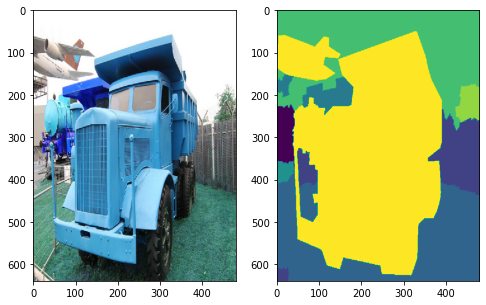

before rescaling: [ 4 21 32 40 48 65 77 91]
after rescaling: [ 96 113 124 132 140 157 169 183]
building-other
fence
grass
metal
pavement
sky-other
tree
other


In [ ]:
if __name__ == '__main__':

  sample = coco_semantic_dataset(flag='test')
  image,target = sample[30]  
  inspect(image,target)

  plt.figure(figsize=(8,15))
  plt.subplot(1,2,1)
  plt.imshow(image.numpy().transpose(1,2,0))

  plt.subplot(1,2,2)
  plt.imshow(target)
  plt.show()

  labels = np.unique(target.numpy())
  sample.get_className(labels)